# Caracterização de eletrofáceis por meio de inteligência artificial com abordagem supervisionada
## Treinamento, teste e análise do modelo

- **Nome do Arquivo**: treinamento_modelo.ipynb
- **Autor**: Rafael Takeguma Goto
- **Versão**: 1.0
- **Data de Criação**: 24/06/2024
- **Data de Modificação**: 25/06/2024

### Descrição: 
Este notebook contém o a etapa do trabalho referente à realização do treinamento, teste e análise do algoritmo de identificação de eletrofáceis a partir dos dados rotulados.

### Leitura do conjunto de dados

O conjunto de dados é constituído por arquivos csv gerados a partir da fusão da extração dos arquivos dlis com os arquivos agp de cada poço.

In [5]:
import glob
import pandas as pd

leituras = []      # Armazena as leituras dos arquivos .csv
nomes = []          # Armazena os nomes obtidos das leituras

for file in glob.glob(r'**/Dados-filtrados' + "/*.csv", recursive=True):
    try:
        # Salva os dados da leitura
        leitura = pd.read_csv(f'{file}')
        leituras.append(leitura)

        # Salva o nome do poço
        nomes.append(file[16:21])
    except:
        print(file)

In [6]:
# Casa itens da lista 'nomes' com os itens da lista 'leituras'
pares = zip(nomes, leituras)

# Cria dicionário 'dados'
dados = dict(pares)

### Número total de registros

O conjunto de dados utilizado neste trabalho possui um total de X registros. O poço P_574 é o que possui o maior número de registros, com 4546. O poço com o menor número de registros é o P_689, com 1620.

In [7]:
registros = {}      # Dicionário para armazenar o número de registros de cada poço

for key, poco in dados.items():
    registros[key] = poco.shape[0]

In [21]:
import matplotlib.pyplot as plt

def criar_grafico_barra_horizontal(x, y, titulo, subtitulo, rotulo_x, rotulo_y):
    plt.figure(figsize=(8,5))

    # barras do gráfico de barras
    plt.barh(y, x, edgecolor='black', color='deepskyblue', zorder=2)

    # Objeto dos eixos
    ax = plt.gca()

    # Muda a cor dos eixos
    ax.spines['top'].set_color('gray')       
    ax.spines['bottom'].set_color('gray')  
    ax.spines['left'].set_color('gray')     
    ax.spines['right'].set_color('gray')  

    # Remove os tracinhos dos eixos
    ax.tick_params(axis='x', which='both', bottom=False, top=False)  
    ax.tick_params(axis='y', which='both', left=False, right=False)  

    # Add um grid
    plt.grid(True, axis='x', zorder=0)

    # Título do gráfico
    plt.suptitle(titulo, fontsize=18, fontweight='bold')

    # Subtitle do gráfico
    if subtitulo:
        plt.title(subtitulo, fontsize=12)

    # labels x e y
    plt.xlabel(rotulo_x, fontweight='bold')
    plt.ylabel(rotulo_y, fontweight='bold')

    plt.show()

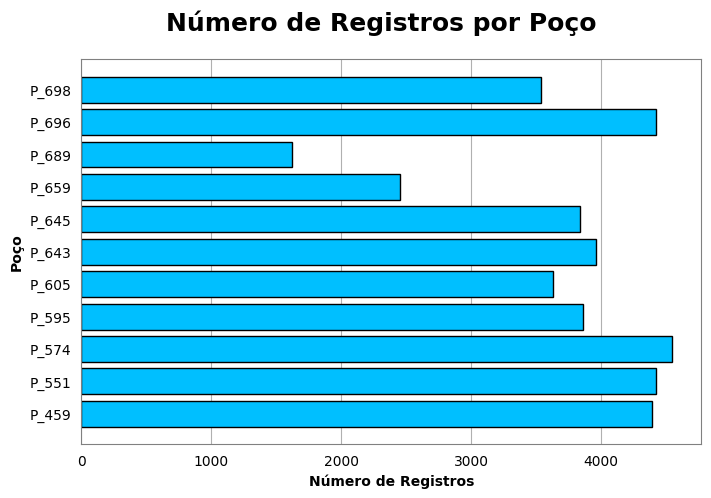

In [22]:
pocos = list(registros.keys())
num_registros = list(registros.values())

criar_grafico_barra_horizontal(num_registros, pocos, "Número de Registros por Poço", "", "Número de Registros", "Poço")

### Número de registros por Formação

In [42]:
def criar_grafico_registros_formacao(poco):
    countsF = dados[poco]['UnidadeF'].value_counts()

    formacoes = list(countsF.keys())
    registros_formacao = list(countsF.values)

    titulo = f"Número de Registros por Formação ({poco})"

    criar_grafico_barra_horizontal(registros_formacao, formacoes, titulo, "", "Número de Registros", "Formação")

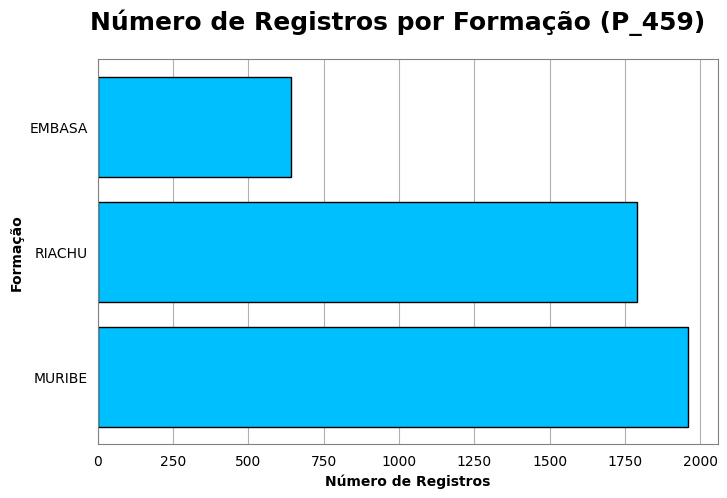

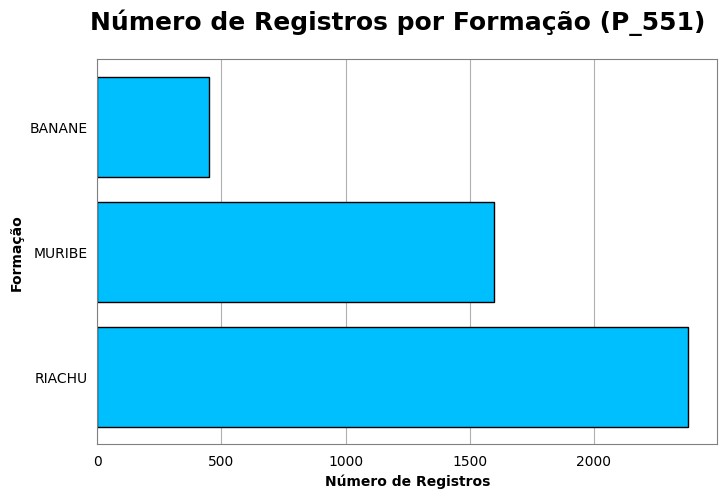

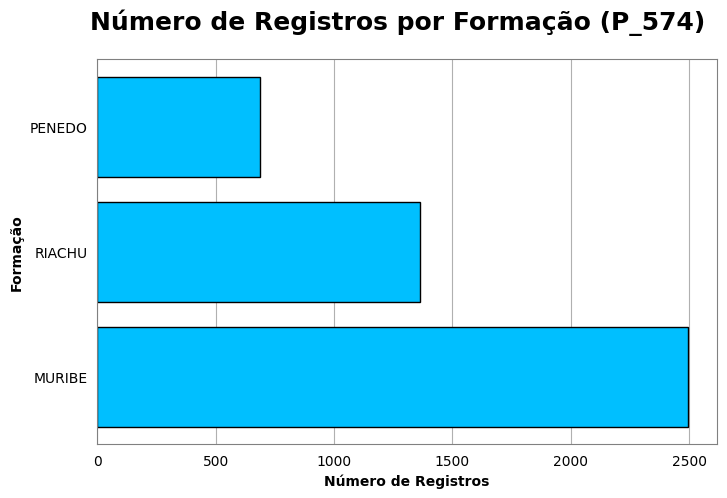

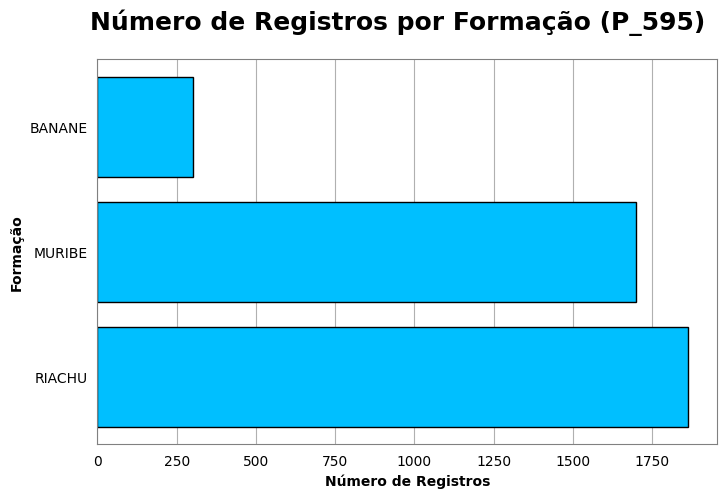

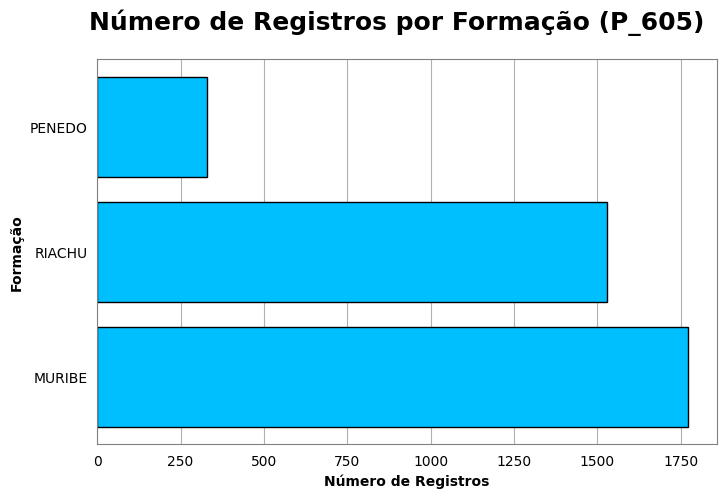

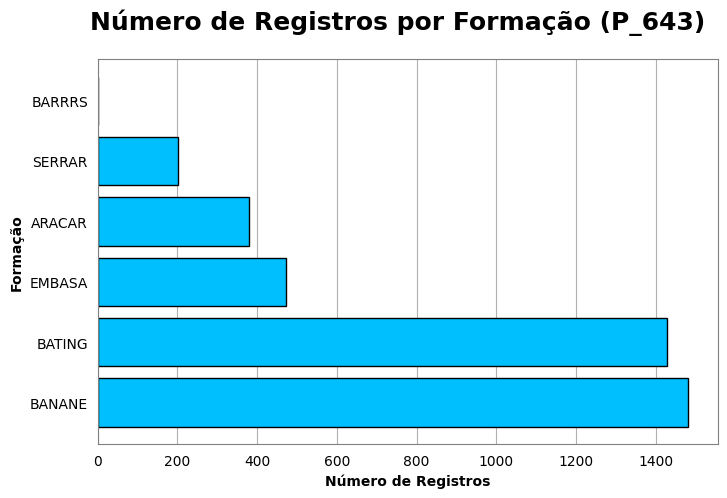

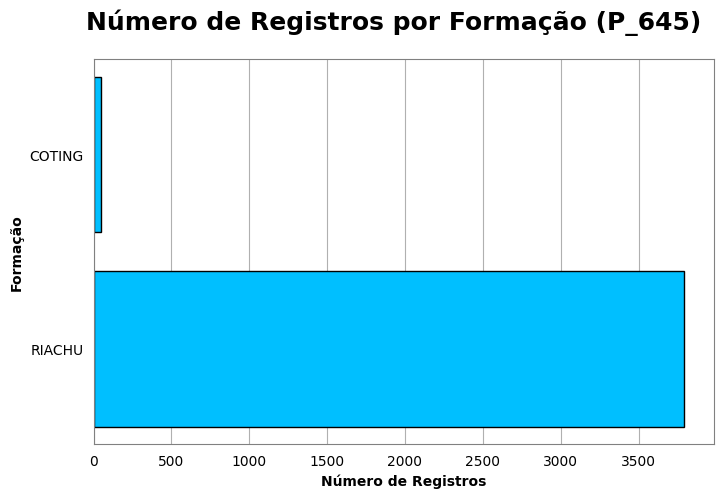

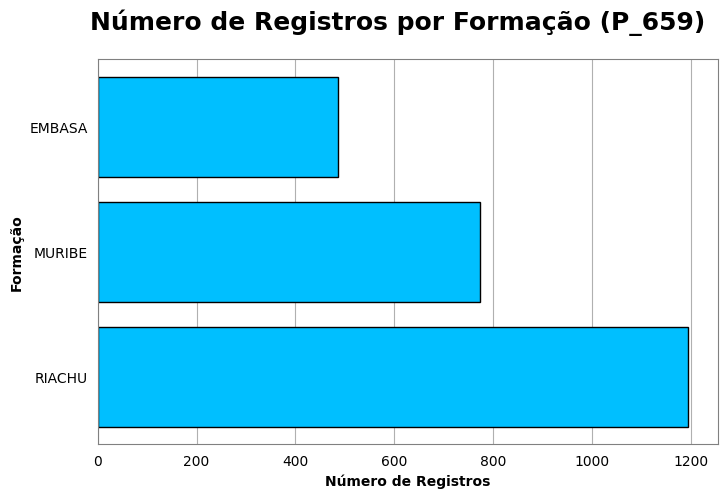

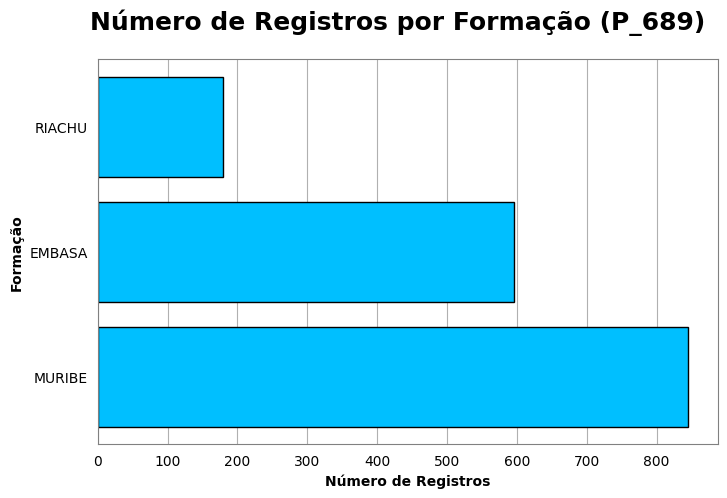

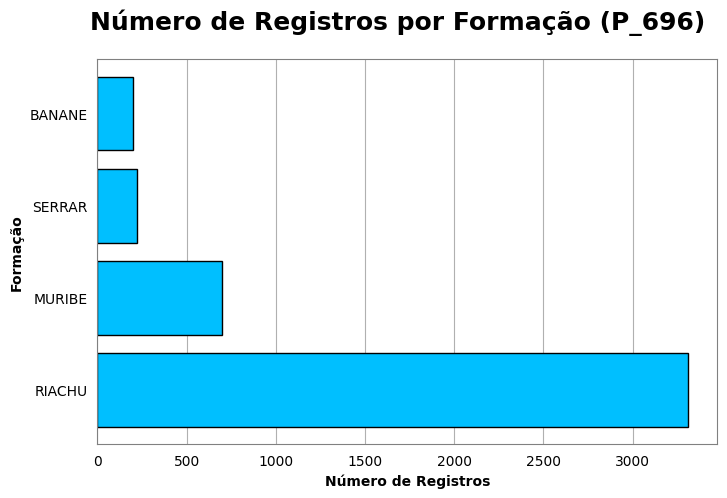

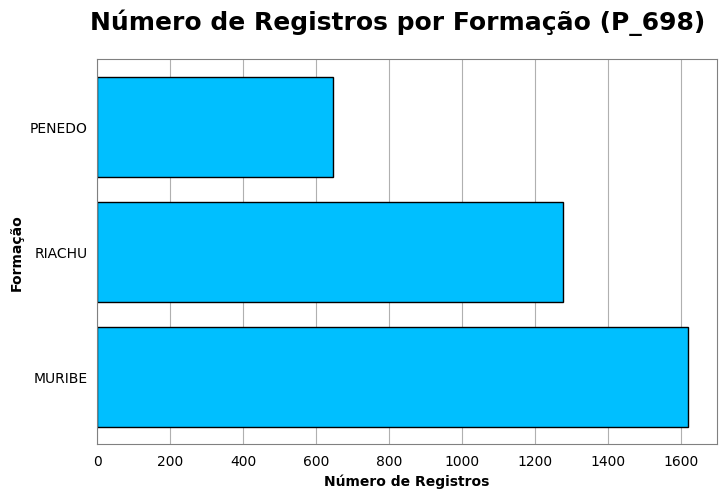

In [44]:
for key in dados.keys():
    criar_grafico_registros_formacao(key)

### Número de registros por Membro

In [47]:
# Função para contar todas as combinações existentes na hierarquia de formação e membro
def count_all_combinations(df, formacao, membro):
    combinations = df.groupby([formacao, membro]).size()
    combinations_dict = {f"{a}_{b}": count for (a, b), count in combinations.items()}
    return combinations_dict

In [54]:
def criar_grafico_registros_membro(poco):
    countsFM = count_all_combinations(dados[poco], 'UnidadeF', 'UnidadeM')

    formacoes = list(countsFM.keys())
    registros_formacao = list(countsFM.values())

    titulo = f"Número de Registros por Membro ({poco})"

    criar_grafico_barra_horizontal(registros_formacao, formacoes, titulo, "", "Número de Registros", "Membro")

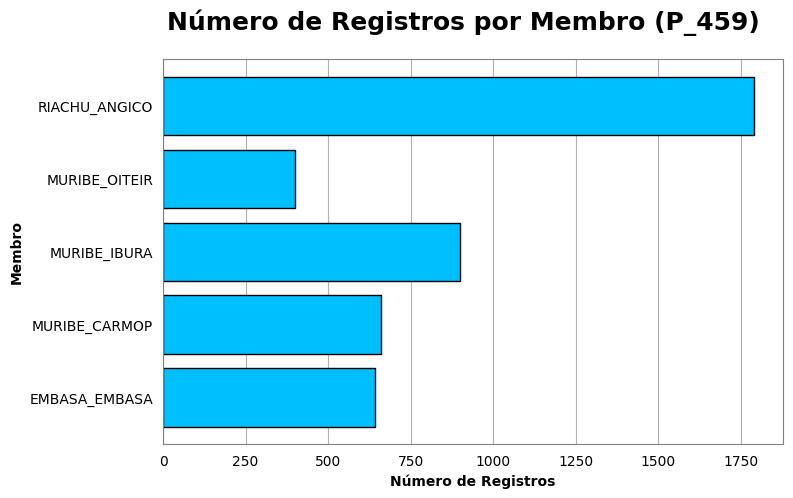

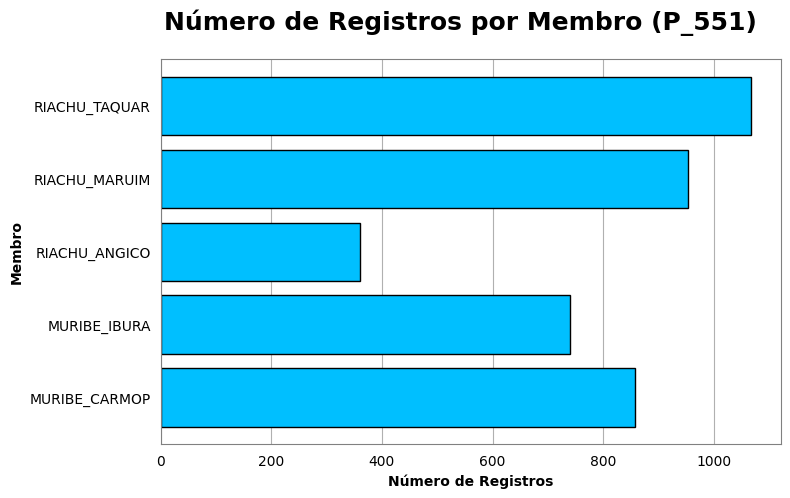

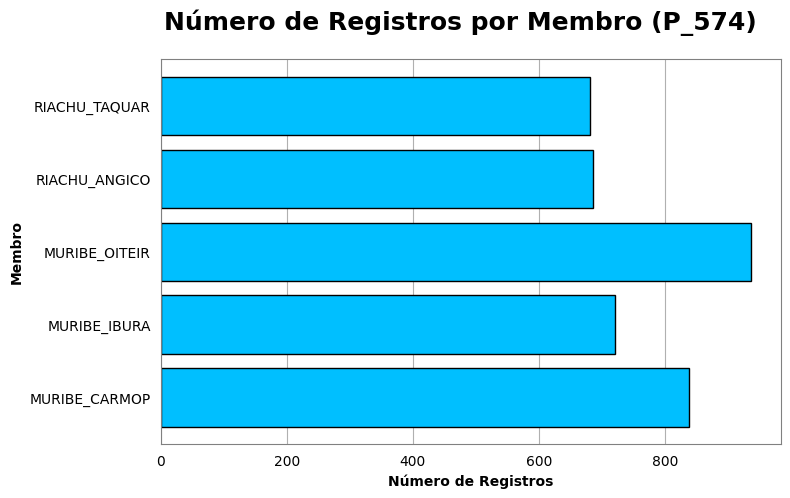

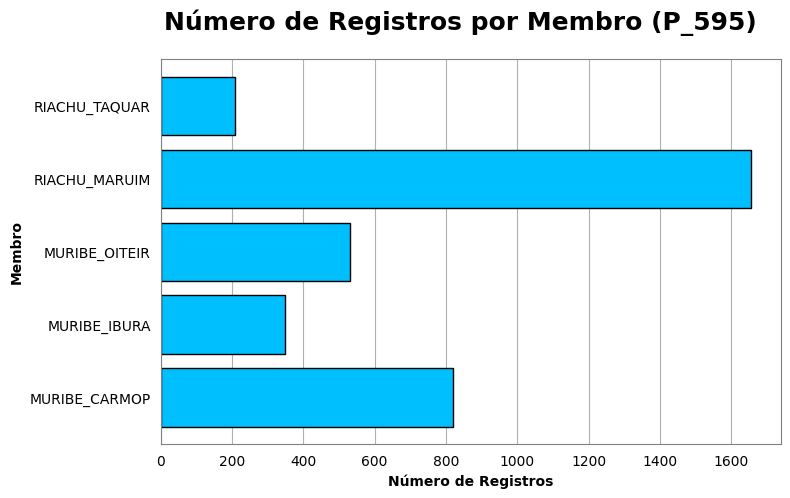

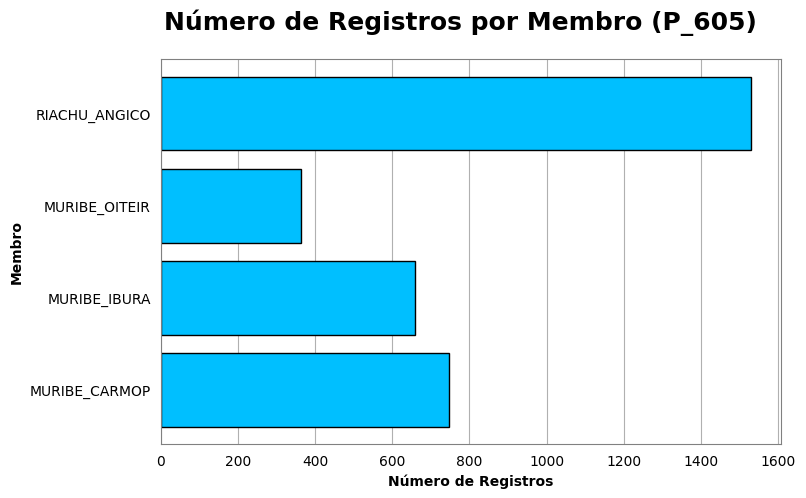

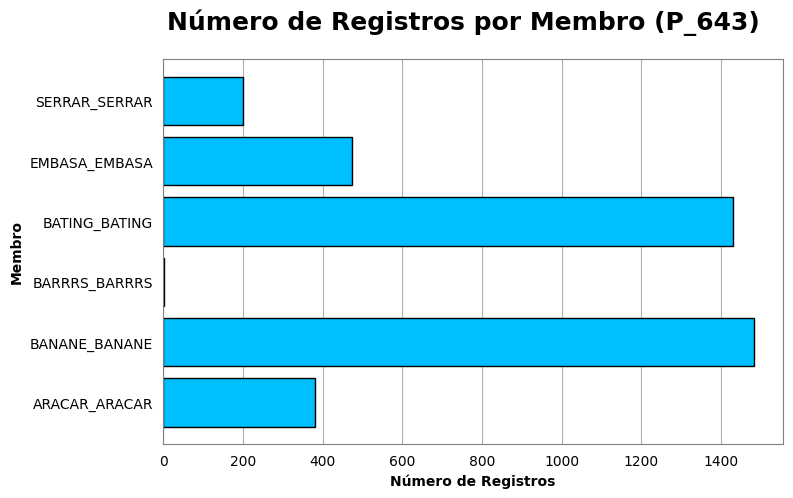

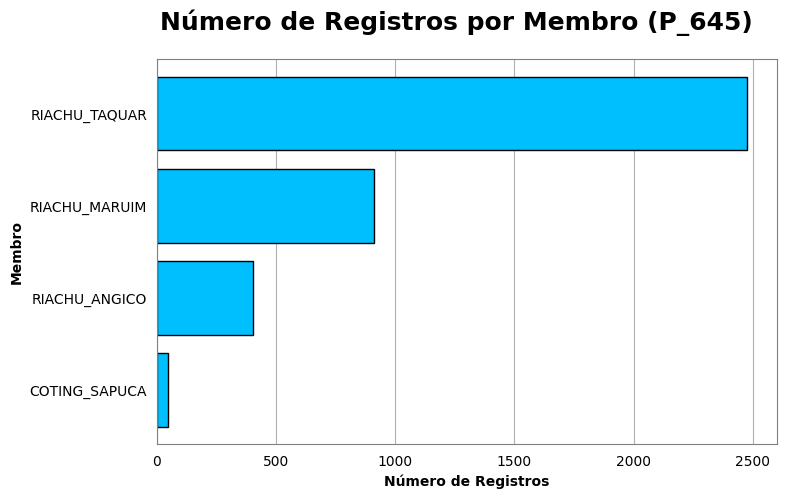

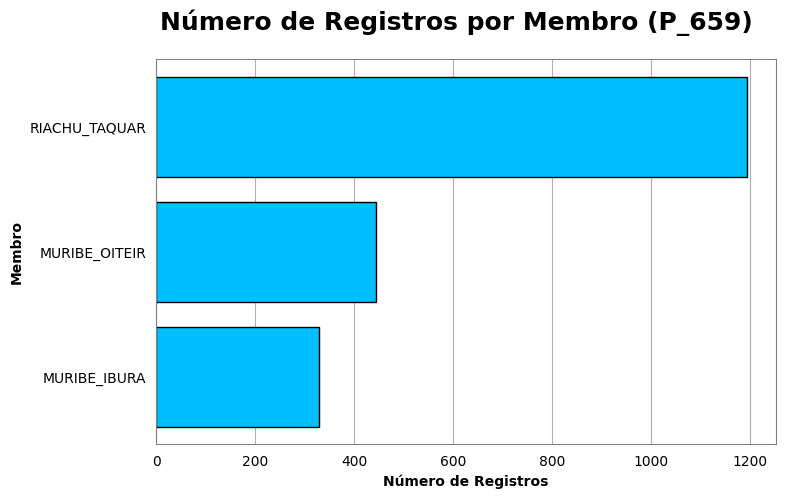

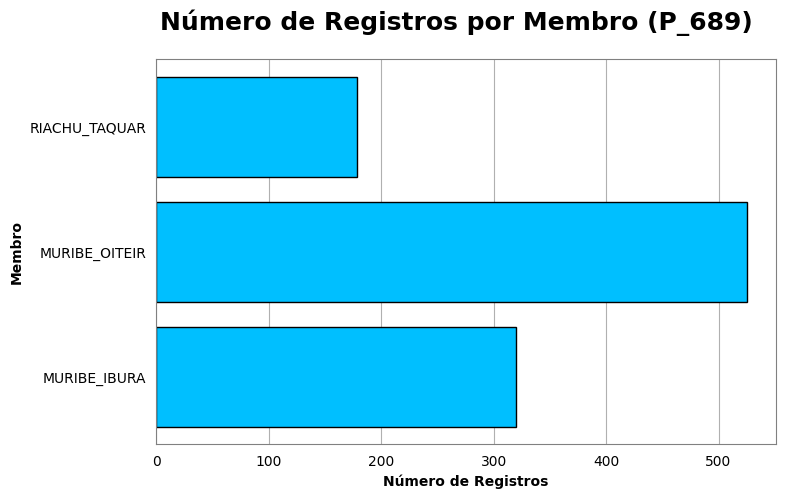

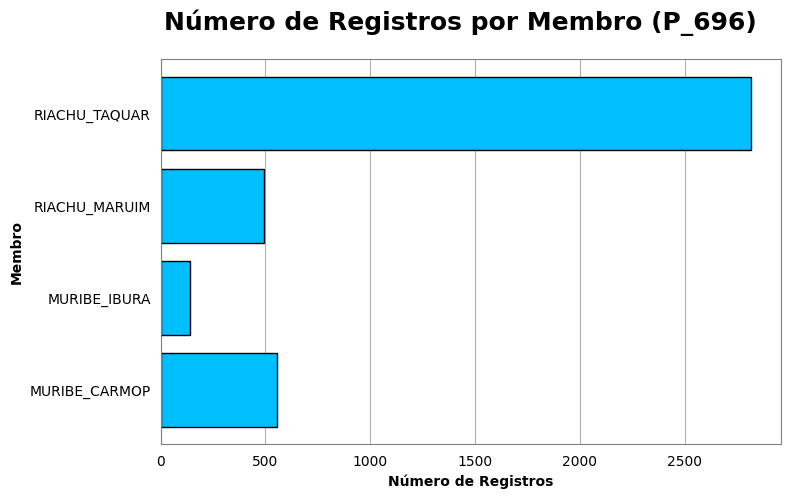

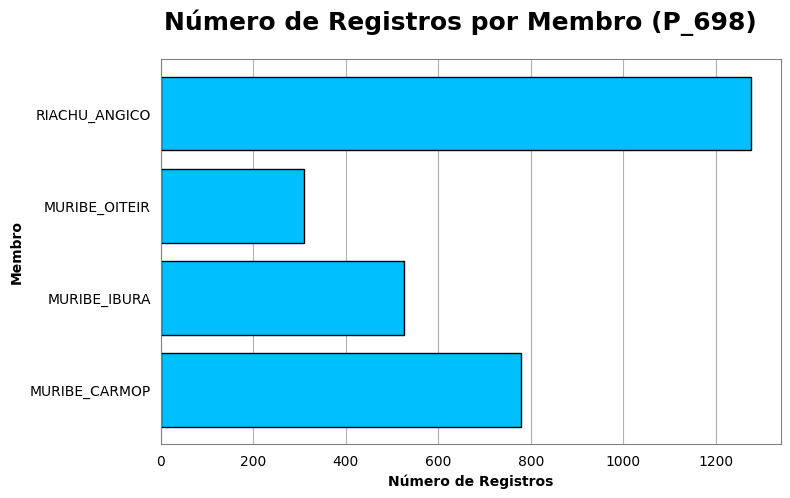

In [55]:
for key in dados.keys():
    criar_grafico_registros_membro(key)

### Divisão do conjunto de dados
A divisão dos dados que serão utilizados pelo algoritmo é feita com base no método *holdout*, do qual divide os dados em proporção de p para o treinamento do algoritmo e (1-p) para o teste do algoritmo. Foi definido p como 2/3, 66.67% dos dados para o treinamento e 33.34% para teste, como geralmente é feito (FACELI et al. 2011).